# Import Libraries

In [46]:
import os
import pandas as pd
import numpy as np

import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

### Model dependencies

In [38]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, Bidirectional

# Preprocessing

## Import data

In [14]:
df = pd.read_csv('../data/twitter_data.csv')

In [15]:
df.head(5)

,id,user,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Missing values

In [16]:
df.isnull().sum()

id             0
user           0
sentiment      0
tweet        686
dtype: int64

In [17]:
df.dropna(inplace=True)

## Feature Analysis

In [18]:
df['length'] = df['tweet'].apply(len)

<Axes: ylabel='Frequency'>

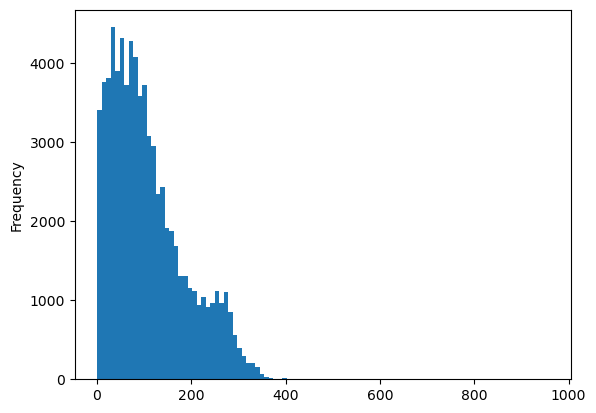

In [55]:
df['length'].plot(bins=100, kind='hist')

In [19]:
df['num_words'] = df['tweet'].apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

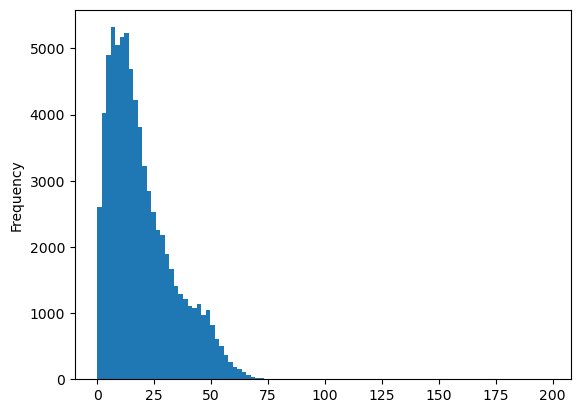

In [56]:
df['num_words'].plot(bins=100, kind='hist')

# Tokenizing

In [22]:
X = df['tweet']
y = pd.get_dummies(df['sentiment'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
max_tokens = 64
num_classes = y.shape[1]

In [32]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
maxlen = 16

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

print(X_train.shape, X_test.shape)

(59196, 16) (14800, 16)


# Sentiment Analysis

## Model Architecture

In [39]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=maxlen))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

## Training

In [51]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=20)

Epoch 1/20
740/740 [==============================] - 9s 12ms/step - loss: 1.1556 - precision: 0.6779 - recall: 0.2459 - val_loss: 1.2328 - val_precision: 0.5973 - val_recall: 0.2082
Epoch 2/20
740/740 [==============================] - 9s 13ms/step - loss: 1.1443 - precision: 0.6840 - recall: 0.2575 - val_loss: 1.2273 - val_precision: 0.6107 - val_recall: 0.2131
Epoch 3/20
740/740 [==============================] - 10s 14ms/step - loss: 1.1318 - precision: 0.6901 - recall: 0.2700 - val_loss: 1.2261 - val_precision: 0.6031 - val_recall: 0.2203
Epoch 4/20
740/740 [==============================] - 10s 14ms/step - loss: 1.1197 - precision: 0.6950 - recall: 0.2805 - val_loss: 1.2270 - val_precision: 0.6057 - val_recall: 0.2185
Epoch 5/20
740/740 [==============================] - 9s 12ms/step - loss: 1.1068 - precision: 0.7027 - recall: 0.2911 - val_loss: 1.2314 - val_precision: 0.5963 - val_recall: 0.2454
Epoch 6/20
740/740 [==============================] - 9s 12ms/step - loss: 1.0966 -

## Results

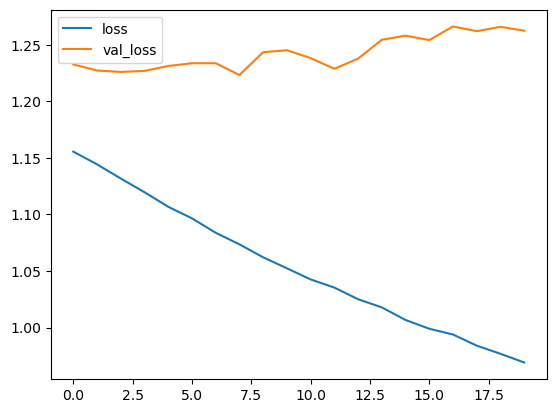

In [52]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

463/463 [==============================] - 2s 3ms/step


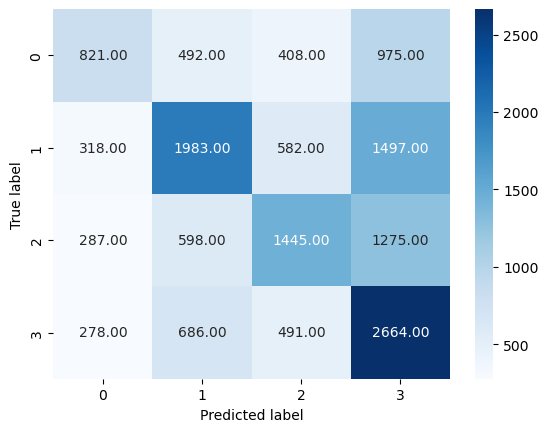

In [53]:
y_pred = model.predict(X_test)

cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='5.2f')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [54]:
print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.48      0.30      0.37      2696
           1       0.53      0.45      0.49      4380
           2       0.49      0.40      0.44      3605
           3       0.42      0.65      0.51      4119

    accuracy                           0.47     14800
   macro avg       0.48      0.45      0.45     14800
weighted avg       0.48      0.47      0.46     14800

